In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from mlxtend.evaluate import bias_variance_decomp

SEED = 314159

In [11]:
data_path = "C:/Users/code/assignment_2"
df = pd.read_csv(f"{data_path}/prepared_data.csv", index_col=0)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


In [12]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### 1(a)Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора. 

In [13]:
depths = np.linspace(1, 10, 10, dtype='int') 
scores_ = []

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
    scores = cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error')
    scores_.append(np.mean(scores))

best_max_depth = depths[np.argmax(scores_)]
print(f"Best max depth: {best_max_depth}")

Best max depth: 5


### 1(b) Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.

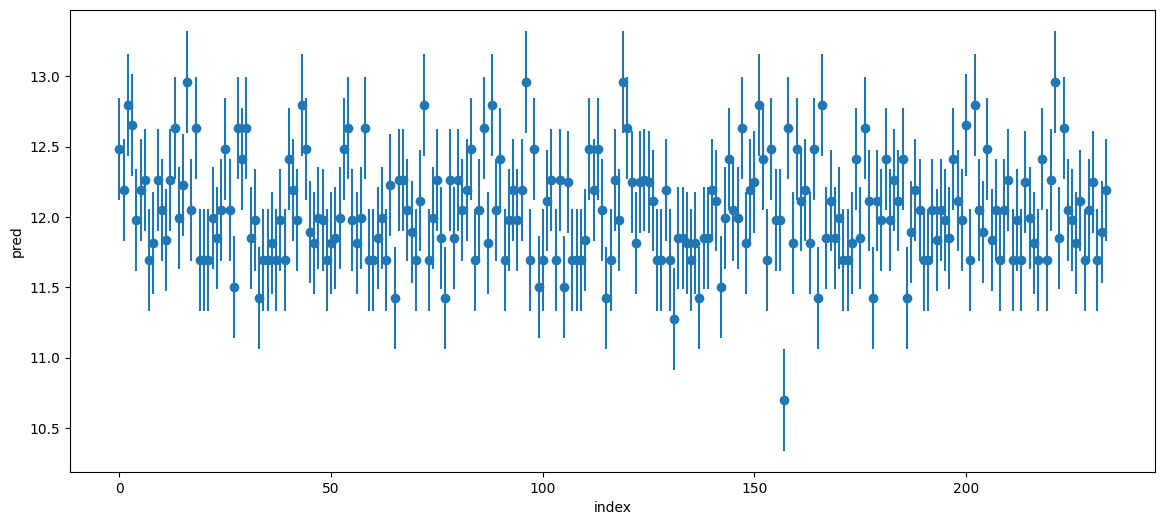

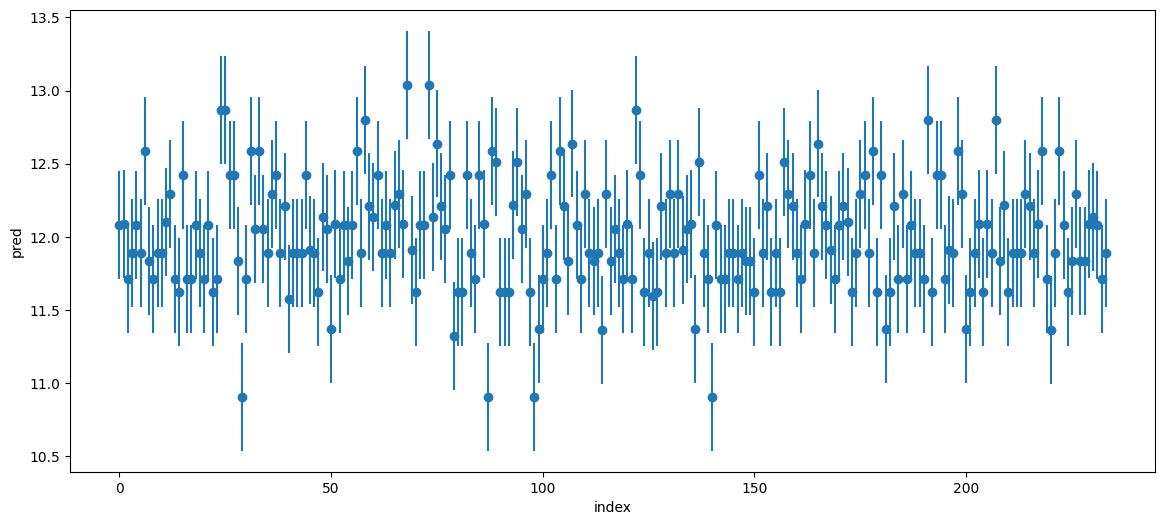

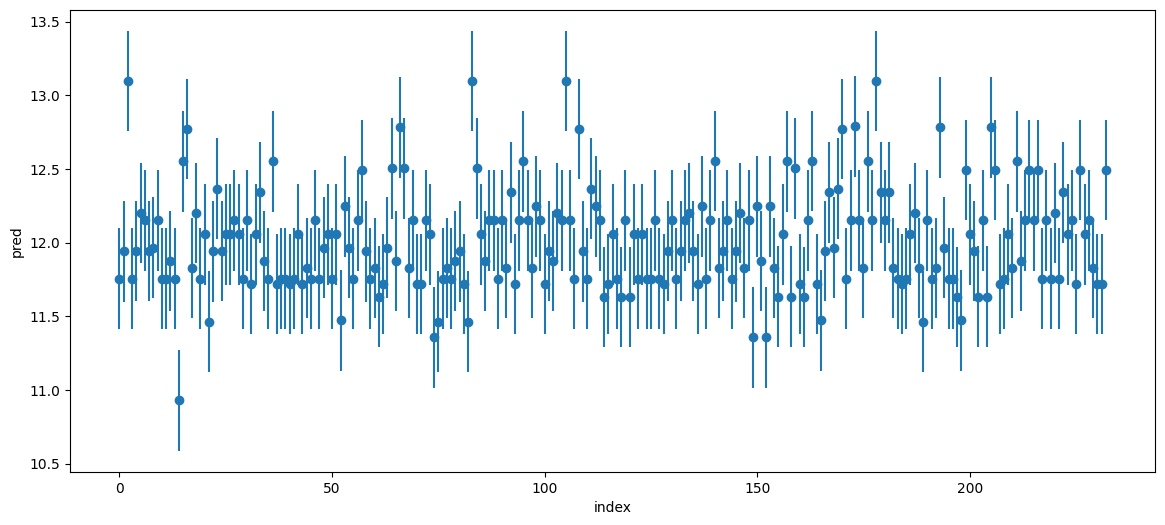

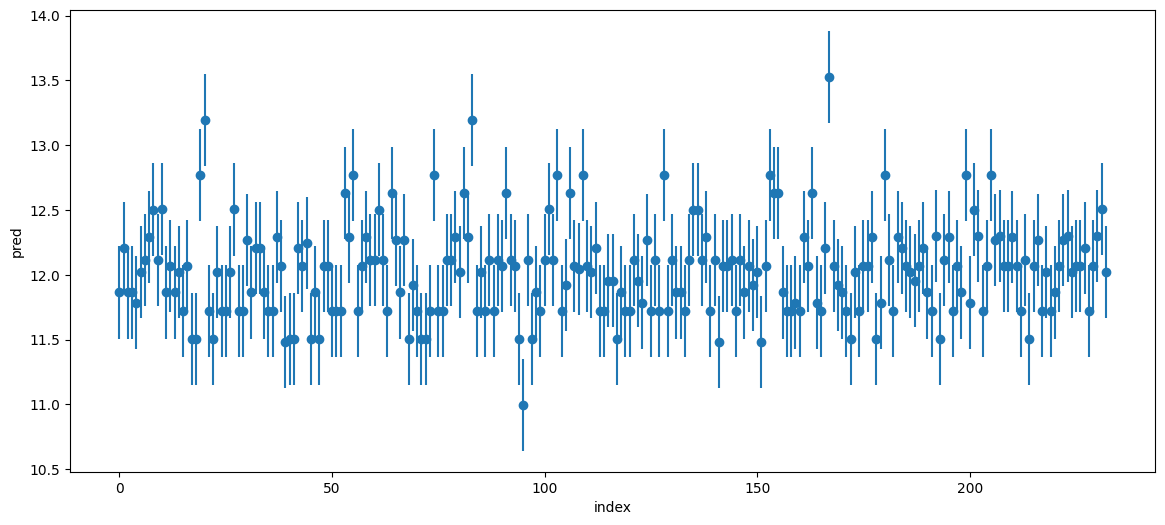

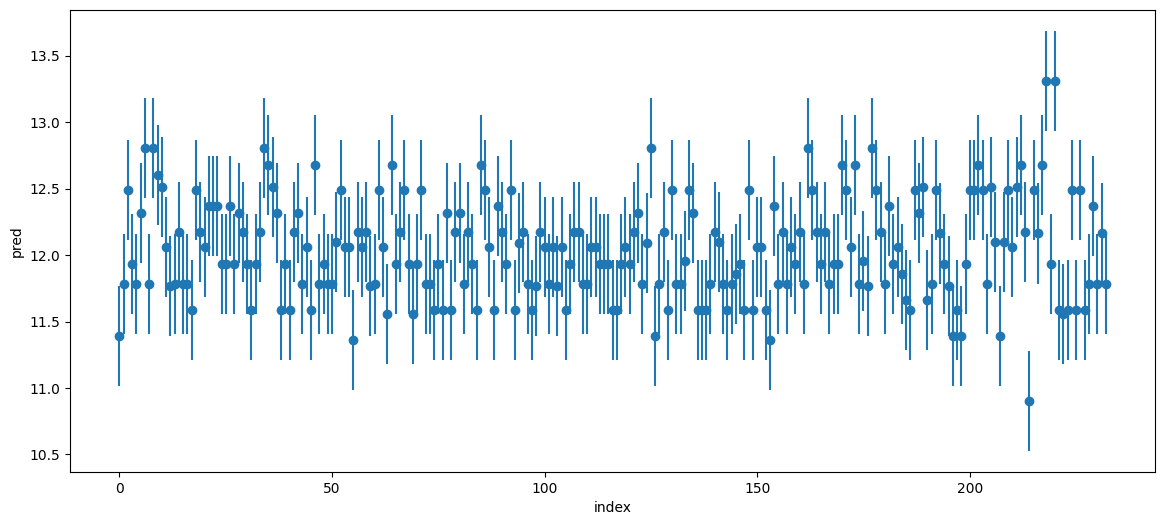

In [14]:
def plot_pred(X, y):
    dt = DecisionTreeRegressor(max_depth=best_max_depth, random_state=SEED)
    kf = KFold()

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index] 
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        fold_std = np.std(y_pred)

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.errorbar(np.arange(0, X_test.shape[0]), y_pred, yerr=fold_std, fmt='o')
        ax.set_xlabel('index')
        ax.set_ylabel('pred')
        plt.show()

plot_pred(X_train, y_train)

### 1(c)Постройте зависимость точности (+/- 2 стандартных отклонения) от числа деревьев

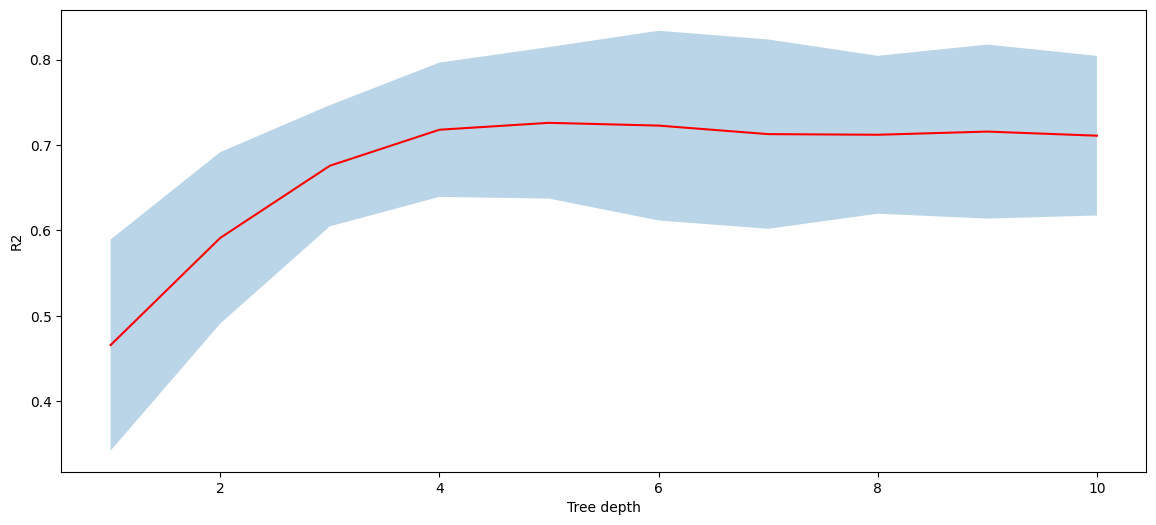

In [15]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
        scores = cross_val_score(dt, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

### 1(d)Визуализируйте предсказания на отложенной выборке. Можно ли получить интервальные предсказания и для нее?

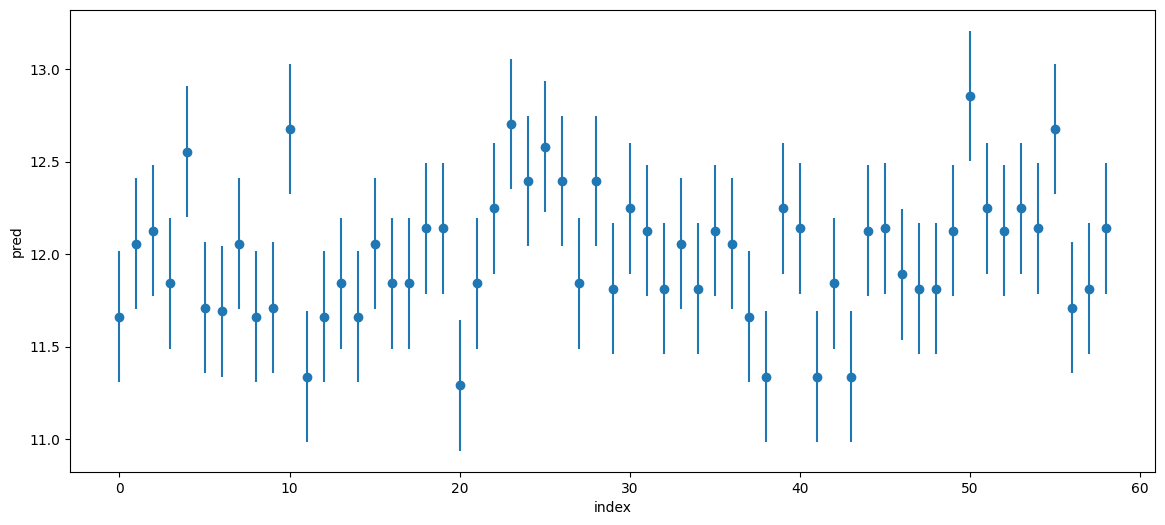

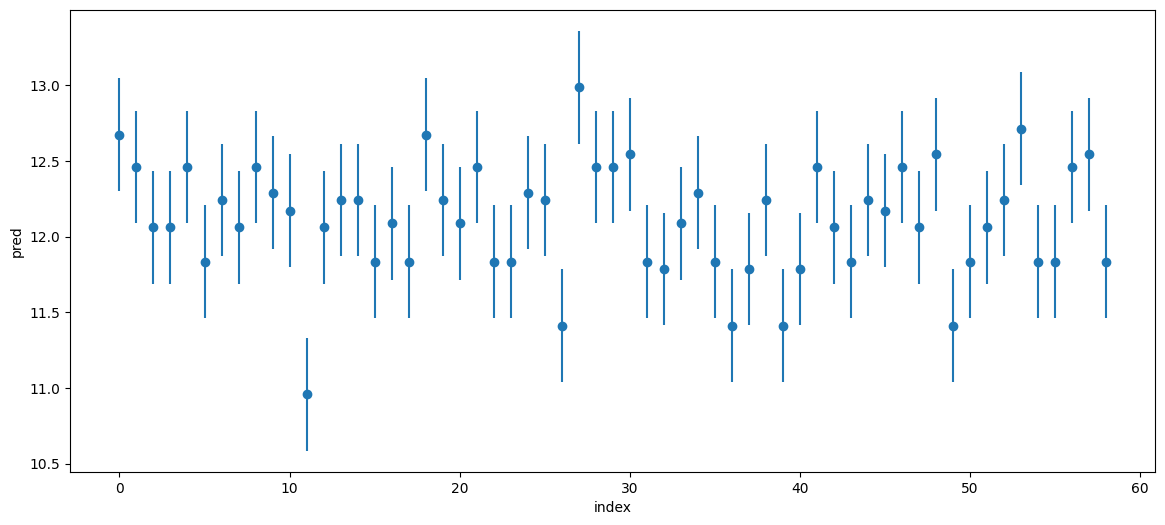

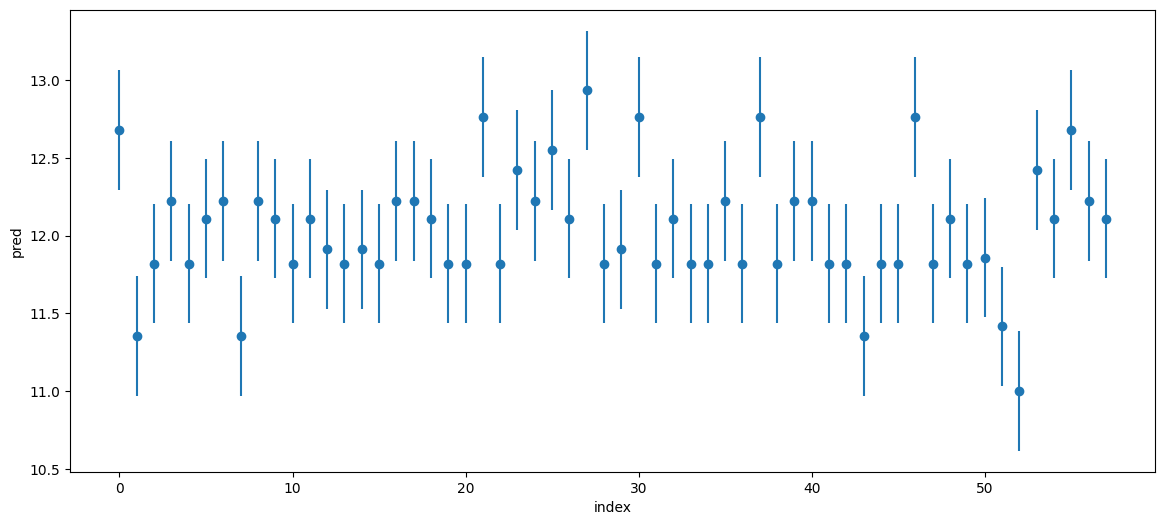

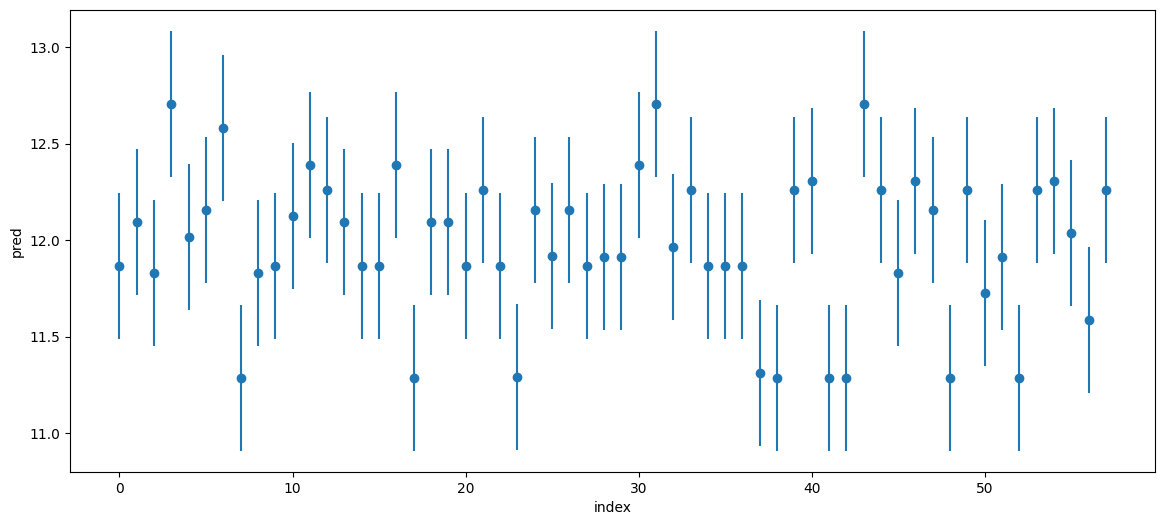

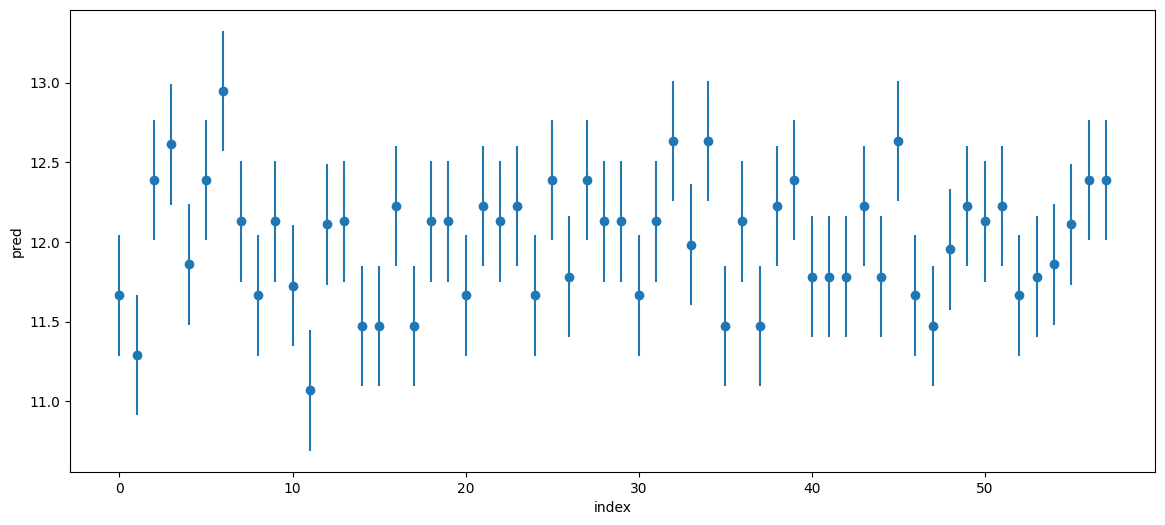

In [16]:
plot_pred(X_test, y_test)

### 2(a)Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

Tree 0 r2 score: 0.6966543852303414
Tree 1 r2 score: 0.737487629048797
Tree 2 r2 score: 0.7477755184074713
Tree 3 r2 score: 0.7384253301053336
Tree 4 r2 score: 0.7385881555459928
Tree 5 r2 score: 0.7045608661838261
Tree 6 r2 score: 0.6711301910759331
Tree 7 r2 score: 0.722672085312958
Tree 8 r2 score: 0.7493617319778262
Tree 9 r2 score: 0.7093591738390566
Ensemble r2 score: 0.7560596029638048


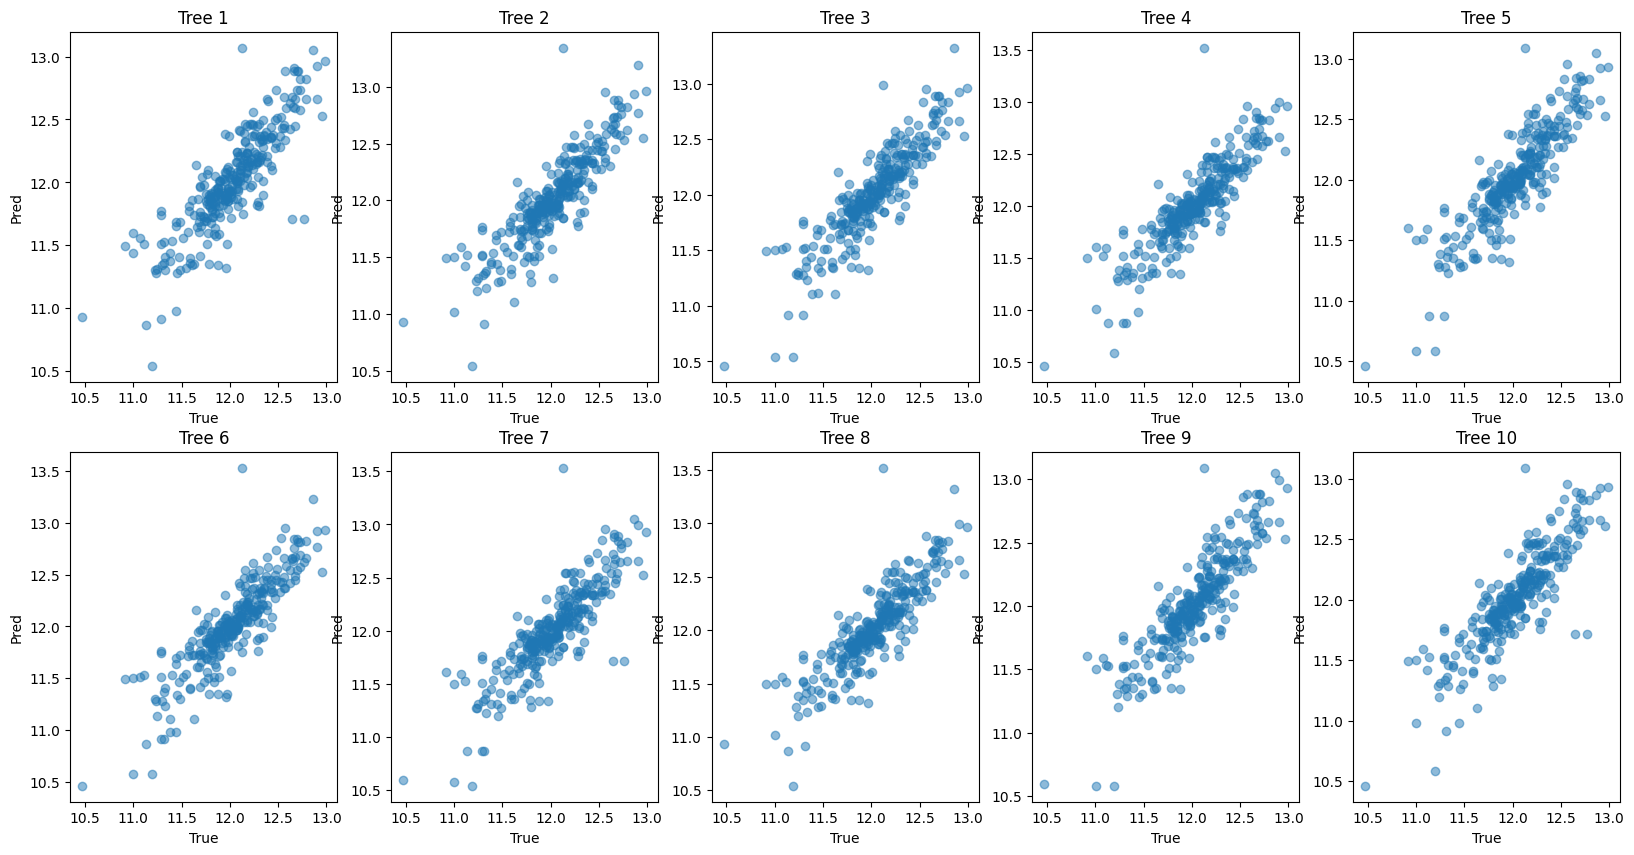

In [17]:
trees = []
individual_r2_scores = []
n_trees = 10

for i in range(n_trees):
    dt = DecisionTreeRegressor(random_state=i).fit(X_train, y_train)
    r_sq = dt.score(X_test, y_test)
    trees.append(dt)
    print(f'Tree {i} r2 score: {r_sq}')

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust number of rows and columns based on n_trees
axes = axes.flatten()

for i, tree in enumerate(trees):
    y_pred = tree.predict(X_test)
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'Tree {i+1}')

estimators = [(f'tree_{i}', trees[i]) for i in range(n_trees)]
ensemble = VotingRegressor(estimators=estimators).fit(X_train, y_train)
r_sq = ensemble.score(X_test, y_test)
print(f'Ensemble r2 score: {r_sq}')

### 2(b)Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [18]:
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=n_trees,
    random_state=SEED,
).fit(X_train, y_train)

r_sq = bagging.score(X_test, y_test)
print(f'Bagging r2 score: {r_sq}')

Bagging r2 score: 0.8574957348318424


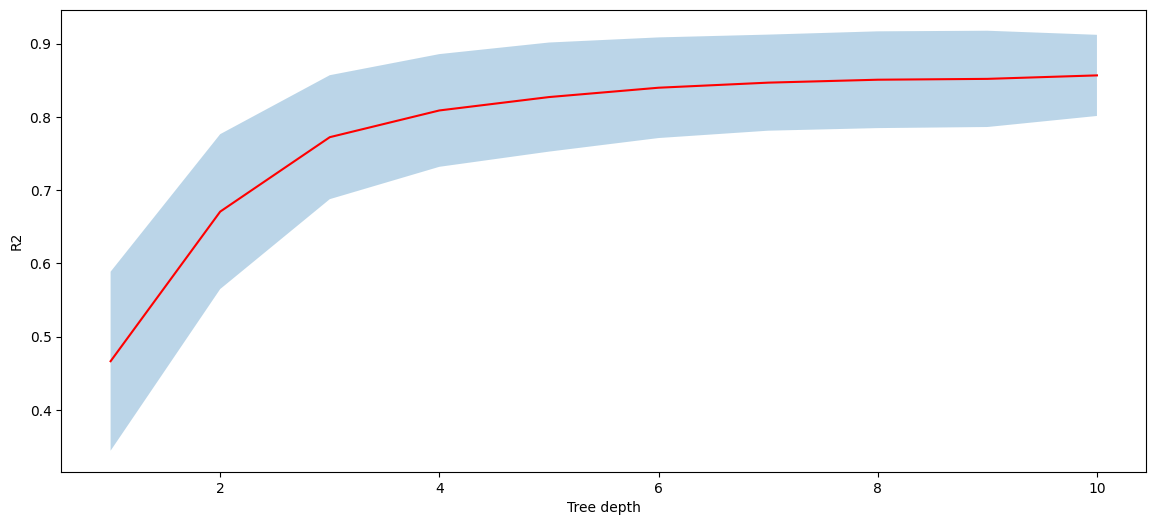

In [19]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        bagging = BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=depth),
            n_estimators=n_trees,
            random_state=SEED
        )
        scores = cross_val_score(bagging, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

### 2(c)Постройте графики зависимости bias-variance в зависимости от числа деревьев.

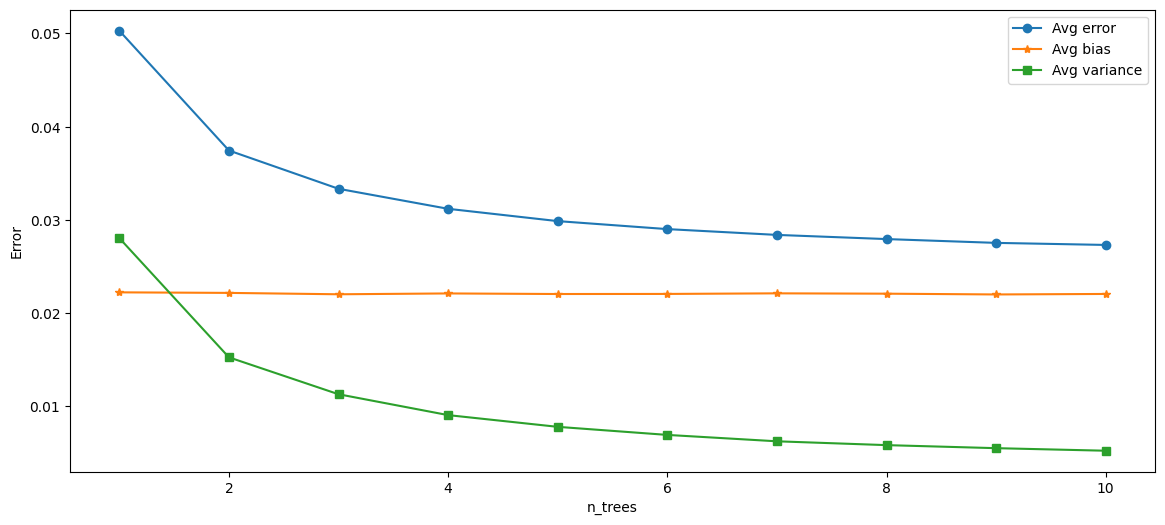

In [20]:
def plot_bias_variance_error_with_cv(X, y):
    n_trees = np.linspace(1, 10, 10, dtype='int')
    errors = []
    biases = []
    variances = []
    kf = KFold()

    X = X.values  
    y = y.values 

    for n_tree in n_trees:
        bagging = BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=7),
            n_estimators=n_tree,
            random_state=SEED
        )

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X):
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                bagging, X_train, y_train, X_test, y_test, loss='mse'
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(n_trees, errors, label='Avg error', marker='o')
    ax.plot(n_trees, biases, label='Avg bias', marker='*')
    ax.plot(n_trees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('n_trees')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()

plot_bias_variance_error_with_cv(X_train, y_train)

### 3 Повторите предыдущие шаги, но для случайного леса.

In [21]:
rf = RandomForestRegressor(
    n_estimators=n_trees, 
    random_state=SEED,
).fit(X_train, y_train)

r_sq = rf.score(X_test, y_test)
print(f'Random forest r2 score: {r_sq}')

Random forest r2 score: 0.8558949789958133


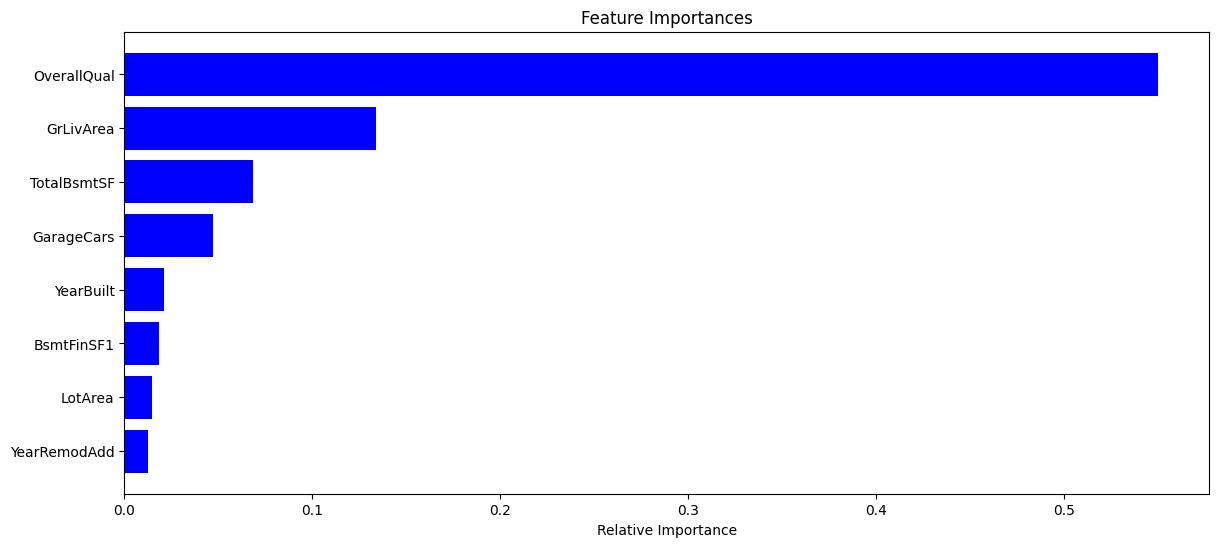

In [22]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
 
num_features = 8 

plt.figure(figsize=(14,6))
plt.title('Feature Importances')

plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
X0=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF']]
X1=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']]
X2=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt', 'BsmtFinSF1',
       'LotArea', 'YearRemodAdd']]
y = df['SalePrice']
X=[X0, X1, X2]
for i in range(len(X)):
       X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=SEED)
       rf = RandomForestRegressor(
              n_estimators=n_trees, 
              random_state=SEED
       ).fit(X_train, y_train)

       r_sq = rf.score(X_test, y_test)
       print(f'Random forest r2 for X{i} important features: {r_sq}')

Random forest r2 for X0 important features: 0.7264060197489676
Random forest r2 for X1 important features: 0.76824975739264
Random forest r2 for X2 important features: 0.8186022816626629


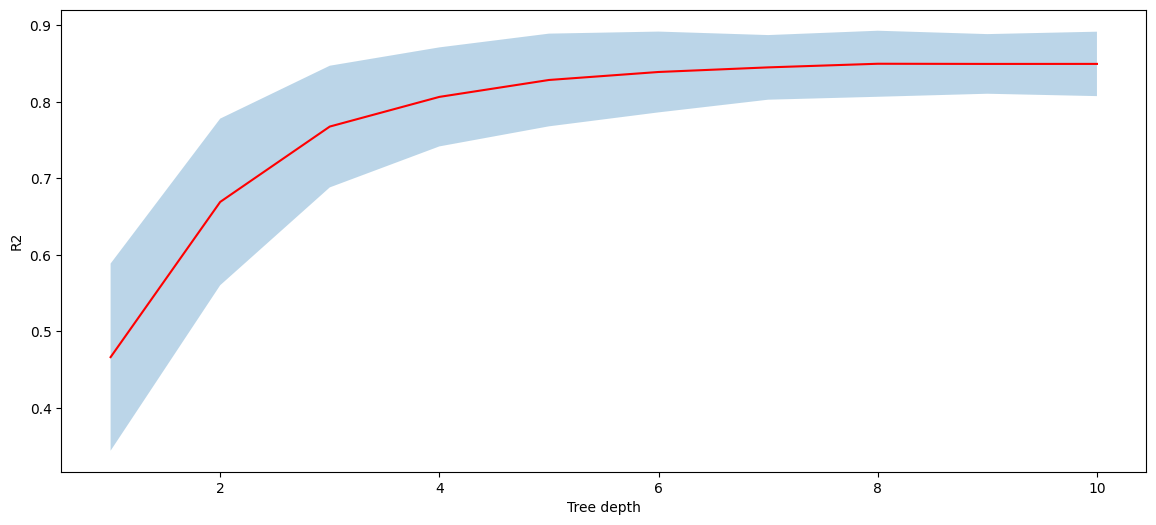

In [24]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        rf = RandomForestRegressor(
            n_estimators=n_trees, 
            random_state=SEED,
            max_depth=depth
        )
        scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

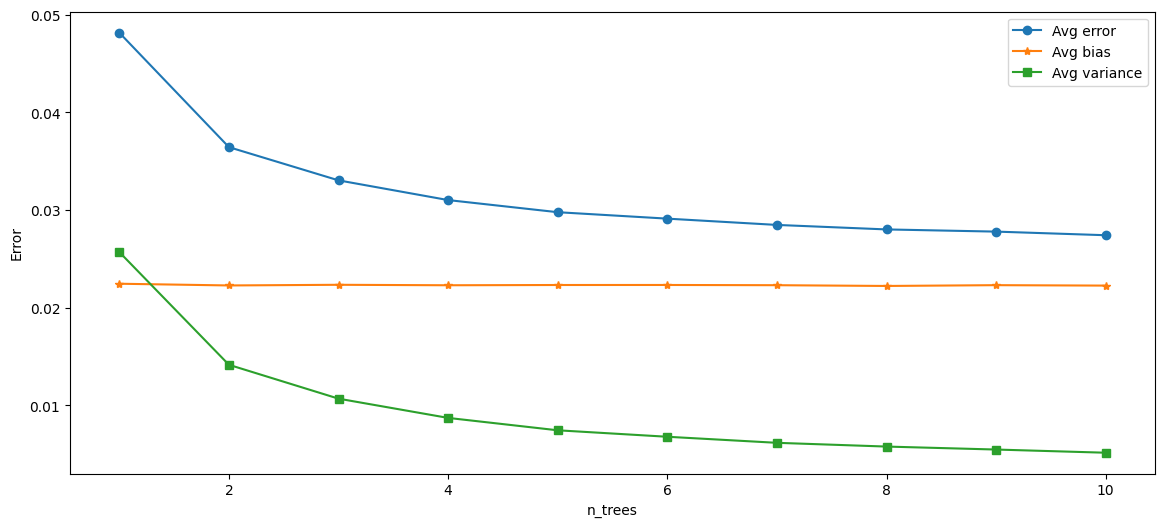

In [25]:
def plot_bias_variance_error_with_cv(X, y):
    n_trees = np.linspace(1, 10, 10, dtype='int')
    errors = []
    biases = []
    variances = []
    kf = KFold()

    X = X.values  
    y = y.values 

    for n_tree in n_trees:
        rf = RandomForestRegressor(
            n_estimators=n_tree, 
            random_state=SEED,
            max_depth=8
        )

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X):
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                rf, X_train, y_train, X_test, y_test, loss='mse'
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(n_trees, errors, label='Avg error', marker='o')
    ax.plot(n_trees, biases, label='Avg bias', marker='*')
    ax.plot(n_trees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('n_trees')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()

plot_bias_variance_error_with_cv(X_train, y_train)